In [3]:
import pandas as pd
import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [pd, np, scipy, sklearn, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 0.25.1
numpy 1.18.5
scipy 1.5.2
sklearn 0.21.3
matplotlib 3.5.3
seaborn 0.12.2


# 5-1 군집화

## 0. 데이터셋 소개

### Gene expression

[유전자 발현](https://www.kaggle.com/datasets/crawford/gene-expression) microarray라는 측정 방법을 사용하여, 급성 골수성 백혈병 환자와 급성 림프구성 백혈병환자를 대상으로 유전자 발현도를 측정한 데이셋입니다. 

[원저자 논문, Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring](https://www.google.co.kr/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiUk_7j6ZWEAxXKlK8BHUkACiYQFnoECCAQAQ&url=https%3A%2F%2Fproteome.gs.washington.edu%2Fclasses%2FGenome372%2FReadings%2FGolub%2520et%2520al%2520Science%25201999.pdf&usg=AOvVaw1RF13kmxmJt8xxhxsx4966&opi=89978449)

해당 데이터는 총 7131개의 컬럼과 72개의 행을 가진 데이터로, 표본의 수보다 속성의 수가 훨씬 많은 데이터셋입니다.

주요 변수 설명

|Name|Type|Description|
|----|---|---------|
|patient|integer|patient no|
|cancer|binary|AML: acute myeloid leukemia<br/>ALL:acute lymphoblastic leukemia|
|train|binary|학습 데이터 여부|

그외 변수는 유전자의 발현도를 정수로 나타낸 변수들 입니다.

데이터 수에 비해서 입력 변수의 수가 많은 데이터셋입니다.

In [4]:
df_gene = pd.read_csv('data/gene.csv', index_col='patient')
df_gene.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer,train
patient,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,ALL,True
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,ALL,True
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,ALL,True
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,ALL,True
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,ALL,True


### Abalone

[Abalone](https://archive.ics.uci.edu/dataset/1/abalone) 데이터셋: 전복의 생육 정보 데이터입니다.


|Name|Data Type|	Meas.|	Description|
|----|---------|-----|-----------|
|Sex|nominal||M, F, and I (infant)|
|Length|continuous|mm|Longest shell measurement|
|Diameter|continuous|mm|perpendicular to length|
|Height|continuous|mm|with meat in shell|
|Whole|continuous|grams|whole abalone|
|Shucked|continuous|grams|weight of meat|
|Viscera|continuous|grams|gut weight (after bleeding)|
|Shell|continuous|grams|after being dried|
|Rings|integer||+1.5 gives the age in years|

분류와 회귀 문제 모두를 다루어 볼 수 있는 데이터셋입니다.

In [5]:
df_abalone = pd.read_csv('data/abalone.csv')
df_abalone.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## 1. 중심기반 군집화

### K-Means

K-Means 군집화는 주어진 데이터를 K개의 군집으로 그룹화하는 기법입니다.

각 군집에는 중심점(Centroid)가 있습니다. 데이터 포인트와 가까운 중심점(Centroid)을 지닌 군집에 속하게 됩니다.


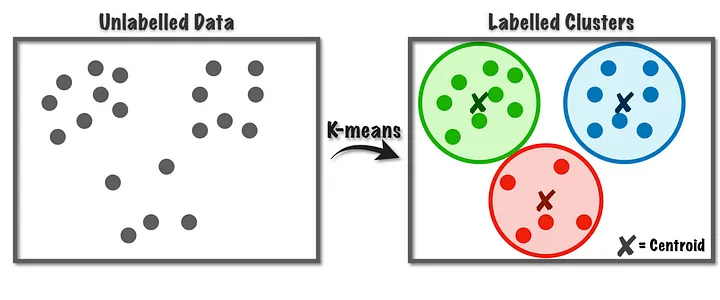

※ 이미지 출처: https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">
    
4개의 중심을 가진 300 개의 2차원 데이터셋을 만들어 봅니다.
    
K-Means 군집화를 이 데이터셋으로 수행을 하고, 결과를 시각화시켜 봅니다.
    
</div>

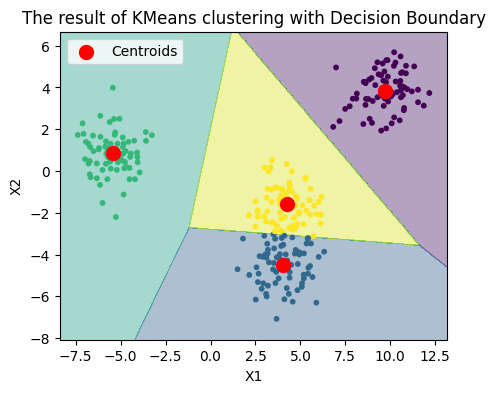

In [6]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# 2차원 가상 데이터 생성
X, _ = make_blobs(n_samples=300, centers=4, random_state=123)

# KMeans 모델 생성 및 학습
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# 결정 경계를 그리기 위한 메쉬그리드 생성
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 각 점에 대한 예측값 계산
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 시각화
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5, 4))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', s=100, c='red', label='Centroids')
plt.title('The result of KMeans clustering with Decision Boundary')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

#### 학습 알고리즘

$S = {S_1, S_2, ..., S_k}$ 는 K-Means 군집에 속한 데이터 포인트의 집합일 때, 중심점은 아래와 같이 정의 됩니다.

$\mu_i = \frac{1}{|S_i|}\sum_{x \in S_i} x $

K-means 모델의 학습은 중심점(Centroid) 과 데이터 포인트의 거리가 최소가 되는 군집화를 목표로 합니다.

> $argsmin_S \sum_{i=1}^k\sum_{x \in S_i}||x - \mu_i||^2$


1. 중심점(Centroid) 초기화

  > Forgy 방법: k개의 서로 다른 임의의 데이터 포인트들을 군집의 중심점(Centroid)으로 초기화합니다.
  > 
  > 랜덤 분할 방법: 각각의 데이터 포인트들을 임의의 군집으로 할당합니다.

2. 할당 단계(Allocation Step): 데이터 포인트에서 가장 가까운 중심점의 군집에 할당합니다.


3. 업데이트 단계(Update Step): 군집에 할당된 데이터 포인트의 중심을 구하여 중심점(Centroid)를 업데이트 합니다..


4. 종료 조건을 확인하고 만족하지 않으면 2번 단계로 이동합니다.


5. 군집의 성능을 측정하고 중심점을 저장합니다.


6. 군집화 반복 조건을 확인하고 반복수를 충족하지 않으면 1번 부터 수행합니다.


> K-Means 군집화는 초기 중심점에 따라 성능이 다릅니다. 초기점을 달리하여 군집화를 수행하여 가장 좋은 결과를 취하기도 합니다.

7. 가장 좋은 성능을 보인 군집화 결과를 최종 군집화 모델로 선정합니다.

**[Ex.2]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_abalone에서 변수 성별(Sex)을 제외한 변수들을 표준화하고 군집화 입력 변수로 합니다.

군집수를 3개로 하고, 군집화를 수행합니다.
    
</div>

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# 성별을 제외하여 입력 변수 리스트를 만듭니다.
X_cols = [i for i in df_abalone.columns if i not in ['Sex']]
# 표준화하여 결과를 DataFrame 형태로 만듭니다.
df_abalone_std = pd.DataFrame(
    StandardScaler().fit_transform(df_abalone[X_cols]), index=df_abalone.index, columns=X_cols
)

In [9]:
n_clusters = 3 # 군집수 입니다.
max_iter = 100 # 최대 중심점 이동수
sse_best = np.inf # 가장 좋은 SSE(Sum of Squared Error)
sse_best_hist = None # 가장 좋았을 때 SSE 기록
n_init = 100 # 초기화 수
sse_last = list()
for _ in range(n_init):
    sse_hist = list() # 중심 이동 때마다 SSE를 기록합니다.
    df_centroid = df_abalone_std.sample(n=n_clusters) # Forgy 방법으로 중심점을 초기회 합니다.
    for i in range(max_iter):
        dist = cdist(df_centroid, df_abalone_std) # 중심점과 데이터 포인트 간 거리를 구합니다.n_clusters×n 행렬 
        clu = np.argmin(dist, axis=0) # 가장 가까운 중심점의 인덱스를 구합니다.
        sse = np.sum(np.min(dist, axis=0) ** 2) # SSE를 구합니다.
        df_centroid = df_abalone_std.groupby(clu).mean() # 중심점을 갱신합니다.: 동일한 군집의 데이터 포인트들의 평균
        if len(sse_hist) > 0 and sse_hist[-1] <= sse: # 중심점이 더 이상 갱신 되지 않으면 종료합니다.
            break
        sse_hist.append(sse)
    if sse_best > sse:
        sse_best = sse
        sse_best_hist = sse_hist
    sse_last.append(sse)
sse_best

9922.77697994091

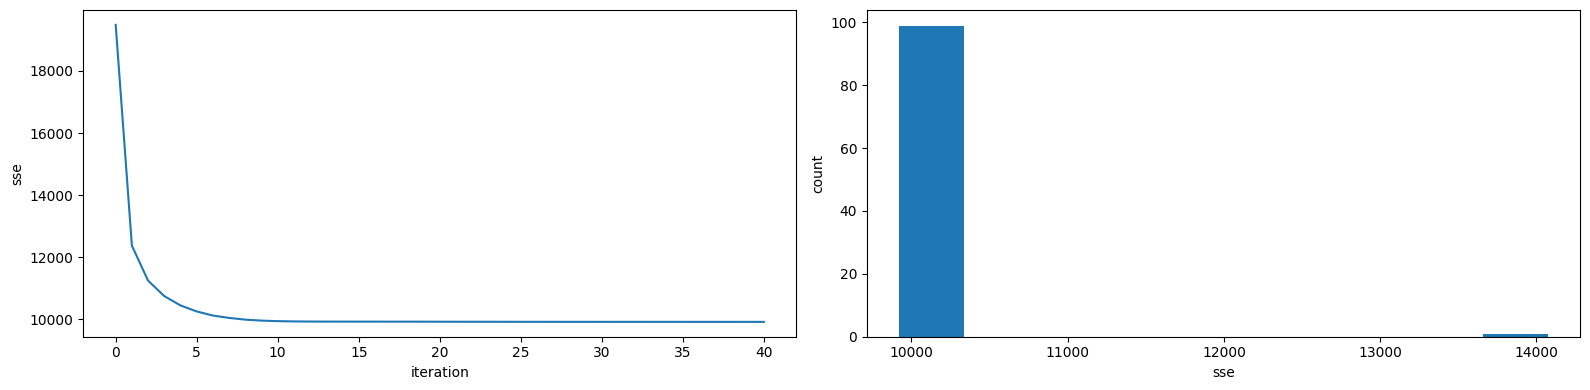

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(sse_best_hist)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('sse')
axes[1].hist(sse_last)
axes[1].set_xlabel('sse')
axes[1].set_ylabel('count')
plt.tight_layout()
plt.show()

**sklearn.cluster.KMeans**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_clusters|군집수|
|n_init|초기화 수|
|max_iter|최대 중심점 이동 루틴 수행수|


In [8]:
from sklearn.cluster import KMeans
clu_km = KMeans(n_clusters=3, n_init=100, max_iter=100)
clu_km.fit(df_abalone_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
clu_km.inertia_

9922.787537696651

### K-Medoids

K-Means와 달리, 군집의 대표점을 군집의 중심점(centroid)로 하는 반면 K-Medoid는 가장 중심에 위치한 데이터 포인트(중심, medoid)입니다.

K-Means는 유클리디언 거리를 사용하여 거리 측정을 하는 반면 K-Medoid는 맨하탄 거리 등 다른 거리 측정 방법을 사용합니다.


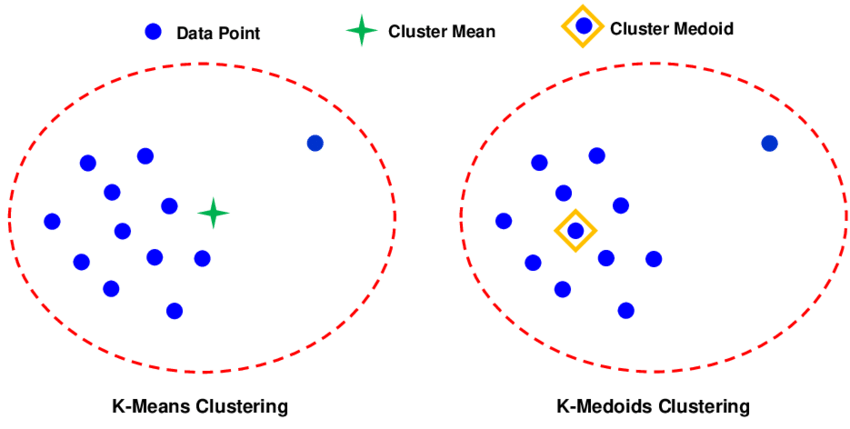

※ 이미지 출처: https://www.researchgate.net/figure/The-graphical-representation-of-the-difference-between-the-k-means-and-k-medoids_fig1_342871651

#### 학습 알고리즘

1. 대표(Medoid) 초기화: 임의의 K개의 데이터 포인트를 선정하여 각 군집의 Medoid로 할당합니다.


2. 할당 단계(Allocation Step): 각 데이터 포인트의 소속 군집을 가장 거리가 인접한 대표(Medoid)점에 해당하는 군집으로 설정합니다.


3. 업데이트 단계(Update Step): 각 군집의 대표점을 군집내의 다른 데이터 포인트와의 거리의 합이 최소인 데이터 포인트로 변경합니다.


4. 종료 조건을 확인하고 만족하지 않으면 2번 단계로 이동합니다.


5. 군집의 성능 측정하고 중심점을 저장합니다.


6. 군집화 반복 조건을 확인하고 반복수를 충족하지 않으면 1번 부터 수행합니다.


> K-Means 군집화는 초기 중심점에 따라 성능이 다릅니다. 초기점을 달리하여 군집화를 수행하여 가장 좋은 결과를 취하기도 합니다.

7. 가장 좋은 성능을 보인 군집화 결과를 최종 군집화 모델로 선정합니다.


#### K-Means와의 비교

- K-Means에 비해 이상치에 덜 민감합니다. 


- 학습시 대표(Medoid)를 구하는 과정에서 추가적인 계산 리소스가 필요합니다.

**[Ex.3]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

Ex.1에서 KMeans 대신에 K-Medoid로 수행합니다. K-medoid은 SSE 대신에 군집의 대표점(Medoid)과 소속 군집의 데이터포인트들과의 거리의합을 측정합니다.
    
</div>

In [28]:
from scipy.spatial.distance import pdist, squareform
n_clusters = 3
max_iter = 100
dist_sum_best = np.inf
n_init = 100
dist_sum_last = list()
df_dist = pd.DataFrame(squareform(pdist(df_abalone_std)),index=df_abalone_std.index, columns=df_abalone_std.index)
for _ in range(n_init):
    dist_sum_hist = list()
    df_medoid = df_dist.sample(n=n_clusters)
    for i in range(max_iter):
        # 군집 할당 단계:  컬럼에는 각 데이터포인트의 인덱스이고, medoid와의 거리가 들어 있습니다.
        clu = df_medoid.idxmin(axis=0).values
        # 동일 군집에 해당하는 거리만을 가져와 합을 구합니다.
        dist_sum = df_medoid.apply(lambda x: x.loc[clu == x.name].sum(), axis=1).sum()
        # 각 군집에서 거리의 합이 최소인점으로 medoid를 갱신합니다. 
        df_medoid = df_dist.loc[
            df_dist.groupby(clu).apply(lambda x: x.loc[:, clu == x.name].sum(axis=1).idxmin())
        ]
        if len(dist_sum_hist) > 0 and dist_sum_hist[-1] <= dist_sum:
            break
        dist_sum_hist.append(dist_sum)
    if dist_sum_best > dist_sum:
        dist_sum_best = dist_sum
        dist_sum_best_hist = dist_sum_hist
    dist_sum_last.append(dist_sum)

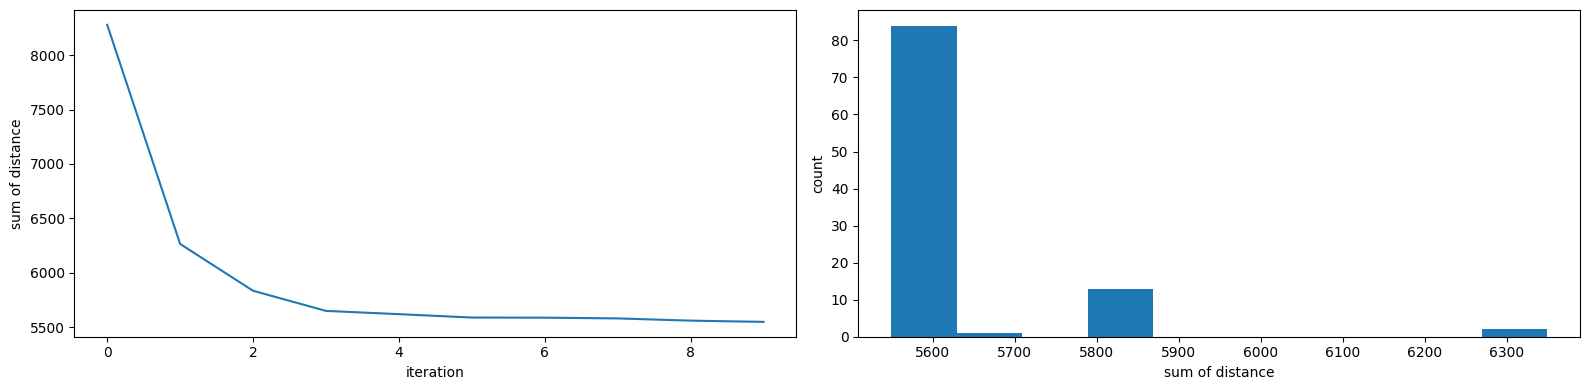

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(dist_sum_best_hist)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('sum of distance')

axes[1].hist(dist_sum_last)
axes[1].set_xlabel('sum of distance')
axes[1].set_ylabel('count')
plt.tight_layout()
plt.show()

검정장 버젼의 sklearn은 K-medoid를 지원하지 않습니다.

## 2. 계층적 군집화 (Hierarchical Clustering)

모든 데이터 포인트 각각이 하나씩 구성된 군집 상태에서 시작하여,

가장 유사도가 높은 군집 쌍(pair)을 우선하여 반복적으로 병합해 가는 방식의 군집화 모델입니다.

모든 데이터가 하나의 군집으로 결합 되면 나무와 같은 형태의 구조를 가집니다.

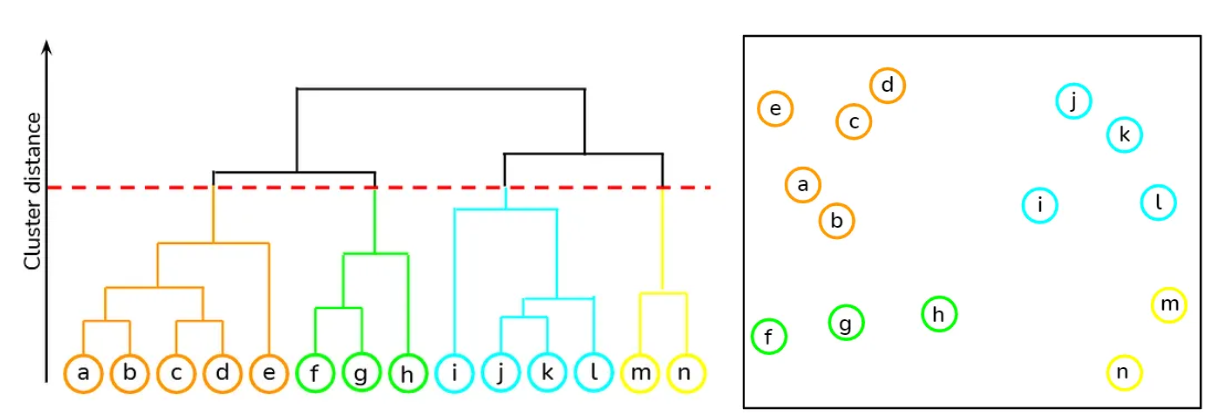

※ 이미지 출처:https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8

### 병합 군집화(Agglomerative Clustering)

#### 군집의 연결(linkage) 기준 측정

군집 A, B의 결합 기준 측정하는 방법입니다.

d(a, b): 데이터 포인트 a와 b의 거리 입니다.

1. 단일 연결(single linkage): $min_{a \in A, b\in B} d(a, b)$


2. 완전 연결(complete linkage): $max_{a \in A, b\in B} d(a, b)$


3. 평균 연결(average linkage): $\frac{1}{|A||B|}\sum_{a \in A}\sum_{b \in B} d(a, b)$

> $|A|$: A의 원소수, $|B|$: B의 원소수

4. 워드 연결(ward linkage): 분산의 증가량이 최소화하는 방향으로 연결합니다.

> Minimum Increase in Sum of Square(MISSQ): $\sum_{x \in A \cup B} ||x - \mu_{A \cup B}||^2 - \sum_{x \in A} ||x - \mu_A||^2 - \sum_{x \in B} ||x - \mu_B||^2$
>
> Minimum Increase in Variance(MIVAR): $Var(A \cup B) - Var(A) - Var(B)$

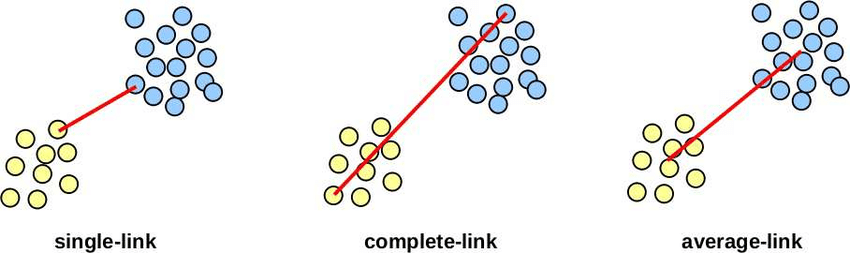

※ 이미지 출처: https://www.researchgate.net/figure/The-three-linkage-types-of-hierarchical-clustering-single-link-complete-link-and_fig57_281014334

**[Ex.4]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_gene에서 train, cancer를 제외하고 표준화를 합니다.

표준화한 데이터프레임으로 평균 연결(average linkage) 방법으로 병합 군집화합니다.
    
</div>

In [12]:
df_gene.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer,train
patient,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,ALL,True
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,ALL,True
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,ALL,True
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,ALL,True
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,ALL,True


In [13]:
df_gene.shape

(72, 7131)

In [14]:
from sklearn.preprocessing import StandardScaler
X_cols = [i for i in df_gene.columns if i not in ['train', 'cancer']]
df_gene_std = pd.DataFrame(StandardScaler().fit_transform(df_gene[X_cols]))
# 병합 군집화의 초기화 과정입니다.
# 현재 군집들의 결합 상태를 d_clu에 저장합니다
# d_clu의 키(key)에는 군집의 번호를, 값에는 소속 군집의 리스트를 저장합니다.
# 초기 상태는 각 데이터 포인트를 소속 군집으로 합니다.
d_clu = {i: [i] for i in range(len(df_gene))} 

from scipy.spatial.distance import pdist, squareform
# average linkage를 사용하므로 각 데이터 포인트간에 거리를 구하는데 사용합니다.
df_dist = pd.DataFrame(
    squareform(pdist(df_gene_std, metric='euclidean')), # 유클리디언 거리를 사용합니다.
    index= df_gene.index, columns = df_gene.index
)

In [15]:
import itertools, heapq
# 병합 군집화는 두 군집의 소속 데이터 포인트간에 최단 군집을 우선으로 결합 시킵니다.
# 현재 결합 대상이 되는 두 군집간의 거리를 저장해 두기 위한 공간입니다.
# 가장 거리가 가까운 두 군집을 뽑기 위한 자료 구조로 Heap을 사용합니다.
h = [] 
# 초기의 결합 후보가 되는 두 군집의 거리를 구하여 h에 넣습니다. 
for i, j in itertools.combinations(d_clu.keys(), 2):
    heapq.heappush(h, (df_dist.iloc[d_clu[i], d_clu[j]].mean().mean(), (i, j)))

초기 군집화 이후 결합이 되는 군집 정보를 **scipy.cluster.hierarchy.dendrogram**(군집 구조 출력 함수) 에서 사용하는 구조에 맞게 저장하여 군집 결과를 출력에 활용할 수 있도록 합니다.

**Z**: 결합 순서에 맞게,  (첫 번째 군집 인덱스, 두 번째 군집 인덱스, 두 군집간 거리, 결합 후 군집수) tuple을 리스트로 만듭니다.

> 군집 인덱스: 결합으로 생긴 군집을 전체 데이터수를 시작하여 군집이 만들어질 때마다 1씩 증가합니다.

scipy.cluster.hierarchy.linkage 매뉴얼 발췌
```
'Z[i, 0]' and 'Z[i, 1]' is given by 'Z[i, 2]'. The
fourth value 'Z[i, 3]' represents the number of original
observations in the newly formed cluster.
```

In [16]:
idx = len(df_gene) # 병합 되는 군집의 인덱스의 시작점입니다. 즉 n이후 인덱스는 결합으로 생긴 군집입니다. 
Z = list()
while len(h) > 0:
    dist, (i, j) = heapq.heappop(h) # heap에서 거리가 가장 가까운 두 데이터 포인트의 거리와 인덱스 가져옵니다.
    if i not in d_clu or j not in d_clu: # 이미 결합이 된 경우에는 건너 뜁니다.
        continue
    new_clu = d_clu[i] + d_clu[j] # 결합 후 데이터 포인트의 인덱스 입니다. 
    del d_clu[i], d_clu[j] # 결합이 되어 새로운 군집이 된 경우는 결합 대상에서 제외합니다.
    # 새로운 군집과 다른 군집간의 average linkage를 계산하여 또 다른 결합 대상을 만듭니다.
    for k, v in d_clu.items():
        heapq.heappush(h, (df_dist.iloc[v, new_clu].mean().mean(), (k, idx))) 
    d_clu[idx] = new_clu # 새로운 군집을 결합 대상에 넣습니다.
    # (첫 번째 군집 인덱스, 두 번째 군집 인덱스, 두 군집간 거리, 결합 후 군집수)
    Z.append((i, j, dist, len(new_clu)))
    idx += 1

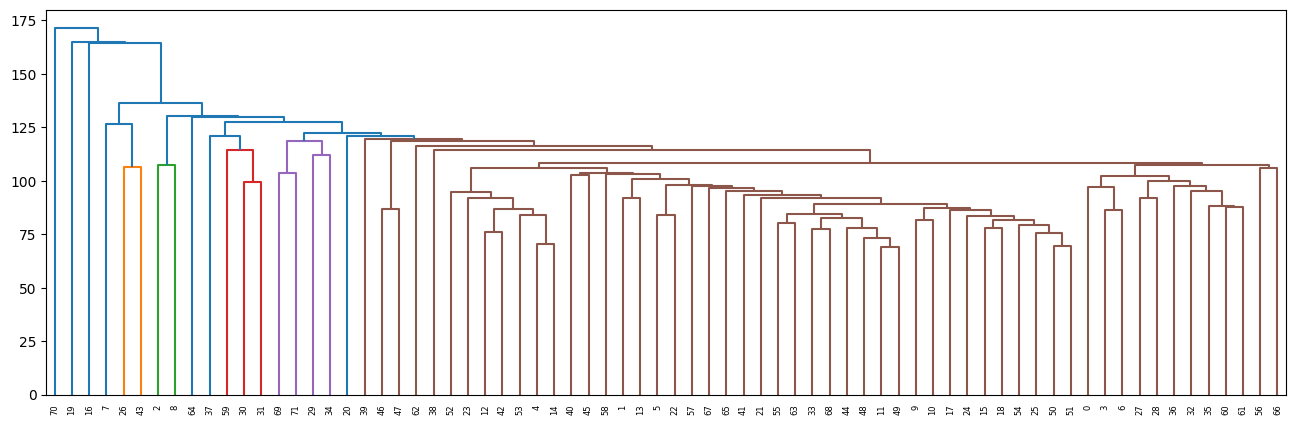

In [17]:
from scipy.cluster.hierarchy import dendrogram
# 군집화 결과를 시각화 합니다.
plt.figure(figsize=(16, 5))
dendrogram(Z)
plt.show()

**scipy.cluster.hierarchy.linkage** : 군집 결합 정보를 만들어 냅니다.

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|y|거리행렬 또는 데이터프레임|
|method|군집 결합 기준 계산 방법, 'single', 'complete', 'average', 'ward'|
|metric|데이터프레임일 경우에 각 데이터 포인트간에 거리 측정 방법|

In [18]:
from scipy.cluster.hierarchy import linkage
Z2 = linkage(squareform(df_dist), 'average')

# 직접 구현해서 나온 결과와 비교합니다.
np.sum(np.array(Z) != Z2)

18

**scipy.cluster.hierarchy.fcluster**: 군집 결합 정보에서 데이터 포인트의 소속 군집을 구합니다.

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|Z|군집 결합 정보|
|t|criterion='maxclust'이면 군집의수<br/> criterion='distance'이면 군집 결합시 거리의 상한선|
|criterion|'maxclust', 'distance'|

In [19]:
from scipy.cluster.hierarchy import fcluster
fcluster(Z, t=2, criterion='maxclust')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1], dtype=int32)

**sklearn.cluster.AgglomerativeClustering**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_clusters|군집수, None을 전단하면 threshold를 기준으로 군집수를 정합니다.|
|affinity|데이터 포인트간 측정 거리, 'euclidean', 'manhattan', 'cosine', 'precomputed' <br/> precomputed일 경우 데이터 포인터간의 거리행렬을 전달합니다.|
|lnkage|군집 결합 기준 계산 방법, 'single', 'complete', 'average', 'ward'|
|distance_threshold|군집을 결합시키기 위한 최소 군집 결합 기준의 상한선|

In [20]:
from sklearn.cluster import AgglomerativeClustering
clu_agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
clu_agg.fit(df_gene_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [21]:
# clu_agg.children_ 에 군집 결합결과가 있습니다.

In [22]:
# 데이터 포인트의 소속 군집이 들어있습니다.
clu_agg.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0], dtype=int64)

## 3. 밀도 기반 군집화(Density-based Clustering)

데이터 포인트들의 밀도를 기반으로 군집을 생성합니다.

### DBSCAN(Density-Based Spatial Clustering of Applications with Noise)

#### DBSCAN에서 데이터 포인트 분류 3가지

- 핵심 포인트(core point): 주변 영역 내에 최소 n개의 이웃 데이터 포인트가 존재하는 데이터 포인트


- 경계 포인트(border point): 주변 영역 내에 n개 만큼 데이터 포인트가 존재하지 않지만 핵심 포인트의 영역안에 있는 데이터 포인트


- 잡음 포인트(noise point): 주변 영역 내에 n개 만큼의 데이터 포인트도 존재하지 않고, 핵심 포인트의 영역안에 있지 않는 데이터 포인트


#### DBSCAN의 주요 요소

- $\epsilon$ 반경: 데이터 포인트의 주변 영역 반경


- 최소 이웃수: 핵심 포인트가 되기 위한 입실론 반경 내의 최소 데이터 포인트 수

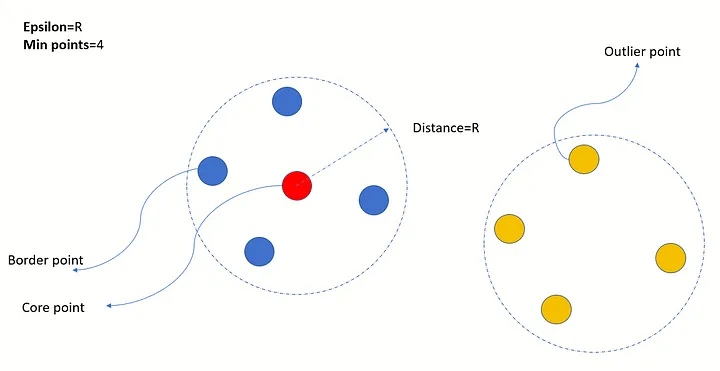

※ 이미지 출처: https://medium.com/@saurabh.dasgupta1/understanding-the-epsilon-parameter-of-dbscan-clustering-algorithm-fe85669e0cae

#### 군집 형성의 기준

상호 밀도연결된(density-connected) 모든 데이터 포인트들은 동일한 군집을 형성합니다.

> 도달가능성(Reachability): 핵심 포인트에서 입실론 반경내의 다른 포인트는 도달 가능성이 있습니다.. 비핵심 포인트에서 다른 포인트로는 도달가능성이 없습니다.
>
> 밀도연결된(density-connected): p와 q에 모두 도달이 가능한 데이터 포인트 o가 존재하면 p와 q는 밀도 연결된 상태입니다.

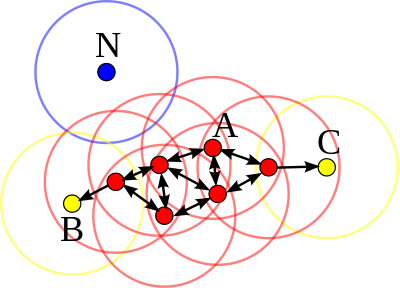

※ 이미지 출처: https://en.wikipedia.org/wiki/DBSCAN

#### 학습 알고리즘

1. 초기화 합니다.

- 데이터 포인트의 군집 상태를 나타내는 영역 label을 정의하고, 모두 상태값을 미정의(undefined)로 초기화합니다.


> label은 미정의(undefined), 잡음 포인트(noise point), 군집 번호를 나타냅니다.

-  C = 0  ← 현재 형성 중인 군집 번호입니다.


- 데이터 포인트마다 $\epsilon$ 반경 이내의 데이터 포인트를 구합니다.

2. label이 undefined 상태인 임의의 데이터 포인트 P를 선택합니다. 선택할 데이터 포인트가 없으면 종료합니다.


3. P의 최소 이웃 수 보다 작으면, label에 noise point라고 표시하고 2단계로 이동합니다.


4. C = C + 1, label(P) = C 로 설정합니다.


5. P에서 도달 가능한 데이터 포인트들을 리스트 S로 정의합니다.


6. S의 모든 데이터 포인트의 label을 C로 저장합니다.


7. S에 데이터 포인트가 없으면 2단계로 이동하고, 아니면 S에서 데이터 포인트 Q를 하나 꺼냅니다.


8. Q의 label이 noise point이면 Q의 label을 C로 설정합니다. Q의 label이 미정의(undefined)가 아니면 7단계로 이동합니다.


9. Q의 label을 C로 설정하고, Q가 핵심 포인트(core point)이면 Q의 이웃 데이터 포인트들을 S에 추가하고 7 단계로 이동합니다.


**[Ex 5]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

2개의 고리 모양을 지닌 2 차원 데이터셋을 만들어,
    
DBSCAN으로 2개의 군집으로 나누어 봅니다.
    
</div>

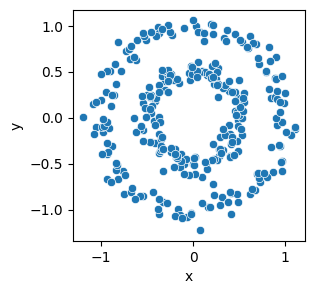

In [23]:
from sklearn.datasets import make_circles

X_circle, _ = make_circles(n_samples=300, factor=0.5, noise=0.07, random_state=123)

df_circle = pd.DataFrame(X_circle, columns=['x', 'y'])
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_circle, x = 'x', y = 'y')
plt.show()

In [24]:
# 다음 구현은 pandas의 기능을 활용하여 위의 알고리즘을 더 간소화 시켰습니다.
# 큰 바탕은 같습니다.
eps_radius = 0.2
minPts = 5
df_dist = pd.DataFrame(squareform(pdist(df_circle)))
s_neighbors_list = df_dist.apply(
    lambda x:x.loc[(x.index != x.name) & (x <= eps_radius)].index.tolist(), 
axis=1)
s_status = s_neighbors_list.apply(lambda x: 0 if len(x) >= minPts else -1) # 0은 핵심 포인트, -1은 잡음 포인트 입니다.
s_status_init = s_status.copy()
C = 0
# 군집이 설정 된 것은 
while True:
    # 핵심 포인트 여부를 나타내는 boolean index를 만듭니다.
    is_core_point = s_status == 0
    # 핵심 포인트가 남아 있지 않으면 중단합니다.
    if is_core_point.sum() == 0:
        break
    # 핵심 포인트를 가져옵니다.
    s_neighbors = s_neighbors_list.loc[is_core_point].sample(n=1)
    C = C + 1
    # 가져온 핵심 포인트의 군집을 C로 설정합니다.
    s_status.loc[s_neighbors.index] = C
    s_neighbors = s_neighbors.iloc[0]
    while True:
        # 이웃의 상태를 가져옵니다.
        s_neighbors_status = s_status.loc[s_neighbors]
        # 잡음 포인트의  이웃을 가져옵니다.
        sub_noise = s_neighbors_status.loc[s_neighbors_status == -1].index
        # 잡음 포인트의 군집을 C로 설정합니다. 이 경우는 경계 포인트입니다.
        if len(sub_noise) > 0:
            s_status.loc[sub_noise] = C
        # 핵심 포인트인 이웃을 가져옵니다. 
        sub_core = s_neighbors_status.loc[s_neighbors_status == 0].index
        if len(sub_core) > 0:
            # 핵심 포인트의 군집을 C로 설정하고
            s_status.loc[sub_core] = C
            # 핵심 포인트들의 이웃을 가져옵니다.
            s_neighbors = s_neighbors_list.loc[sub_core].explode().unique()
        else:
            # 핵심 포인트가 없다면 멈춥니다.
            break

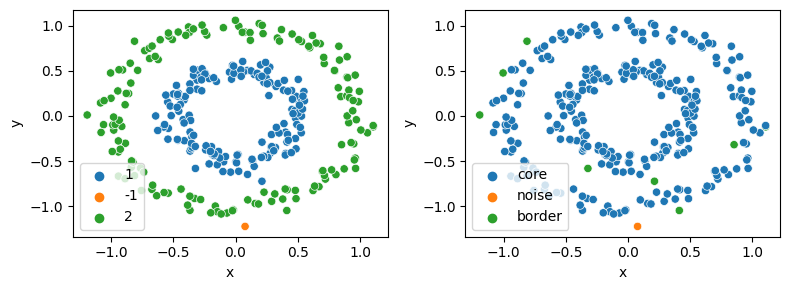

In [25]:
fig, axes= plt.subplots(1, 2, figsize=(8, 3))
sns.scatterplot(x = df_circle['x'],y = df_circle['y'], hue=s_status.astype('str'), ax=axes[0])
sns.scatterplot(x = df_circle['x'],y = df_circle['y'],
                hue=np.where((s_status != -1) & (s_status_init == -1), "border", np.where(s_status == -1, "noise", "core")), 
                ax=axes[1])
plt.tight_layout()
plt.show()

**sklearn.cluster.AgglomerativeClustering**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|eps|$\epsilon$ 반경|
|min_samples|핵심 포인트가 되기 위한 $\epsilon$ 반경 이내의 최소 표본수(자기 자신 포함) <br/> 이론에서는 자기 자신을 포함하지 않는 케이스로 다루었지만 sklearn의 DBSCAN의 구현은 자기 자신 포함하지 않고 핵심 포인트를 산정하고 있습니다.|

In [26]:
from sklearn.cluster import DBSCAN
clu_dbscan = DBSCAN(eps=eps_radius, min_samples=minPts + 1)
clu_dbscan.fit(df_circle)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=6, n_jobs=None, p=None)

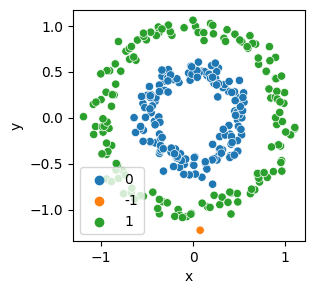

In [27]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x = df_circle['x'],y = df_circle['y'],hue=clu_dbscan.labels_.astype('str'))
plt.show()

## 4. 혼합 모델 기반 군집화(Mixture Model-Based Clustering)

데이터가 여러 개의 확률 분포의 혼합으로 이루졌다고 가정하고 군집을 형성합니다.

### 가우시안 혼합 모델(Gaussian Mixture Model)

- 가우시안 혼합 모델은 데이터의 분포를 여러 개의 가우시안 확률 모델의 선형 결합으로 나타냅니다. 


- 데이터 포인트가 속할 확률이 가장 높은 확률 모델이 데이터 포인트의 군집이 됩니다.


- K-Means 모델 처럼 초기 모수에 따라 성능의 차이가 납니다. 여러 번의 시행 중에 가장 좋은 결과를 보이는 모델을 선정합니다.


#### 학습 알고리즘

- EM 알고리즘을 사용하여 학습합니다. 

5-3 의 EM 알고리즘을 다변량 가우시안 분포 버젼으로 일반화 합니다.

$\theta = (\mu, \Sigma, \tau)$

> $X_i | Z_i = 1 \sim N(\mu'_1, \Sigma'_1)$, ... , $X_i | Z_i = j \sim N(\mu'_j, \Sigma'_j)$

> $P(Z = 1) = \tau'_1$, ... ,$P(Z = i) = \tau'_i$, 

$T_{j,i} = \frac{P(X_i = x_i | Z_i = j; \theta') P(Z=j)}{\sum_{k = 1}^CP(X_i = x_i | Z_i = k; \theta') P(Z = k)}$

$\tau_j = \frac{1}{n}\sum_{i=1}^n T_{j,i}$, 

$\mu_j = \frac{\sum_{i=1}^nT_{j,i}x_i}{\sum_{i=1}^n T_{j,i}}$, 

$\Sigma_j = \frac{\sum_{i=1}^nT_{j,i}(x_i - \mu_j)^T(x_i - \mu_j)}{\sum_{i=1}^n T_{j,i}}$

**[Ex 5]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

3개 다변량 가우시안 분포가 합쳐진 2차원 데이터셋을 만들어서,

가우시안 혼합 모델을 EM 알고리즘으로 학습하고, 이 과정을 출력해봅니다.
    
</div>

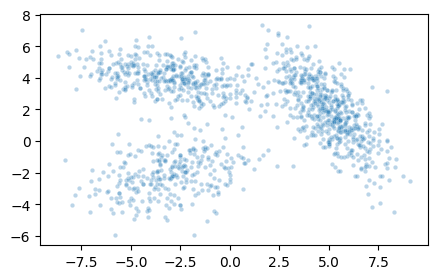

In [28]:
# multivariate_normal: 다변량 가우시안 분포의 기능을 담고 있는 모듈입니다.
from scipy.stats import multivariate_normal

plt.figure(figsize=(5, 3))

x1 = multivariate_normal.rvs(mean = (-3, -2), cov=[[4, 1], [1, 2]], size=300, random_state=123)
x2 = multivariate_normal.rvs(mean = (5, 2), cov=[[2, -2], [-2, 4]], size=550, random_state=123)
x3 = multivariate_normal.rvs(mean = (-3, 4), cov=[[5, -1], [-1, 1]], size=400, random_state=123)
X = np.vstack([x1, x2, x3])
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.3, s=10)
plt.show()

In [29]:
n_mixture = 3
n = X.shape[0]
dim = X.shape[1]

np.random.seed(123)
m = np.random.uniform(size=(n_mixture, dim))
m = m - m.mean() + X.mean()

cov = [np.eye((dim)) for i in range(n_mixture)]
tau = np.ones(n_mixture) / n_mixture

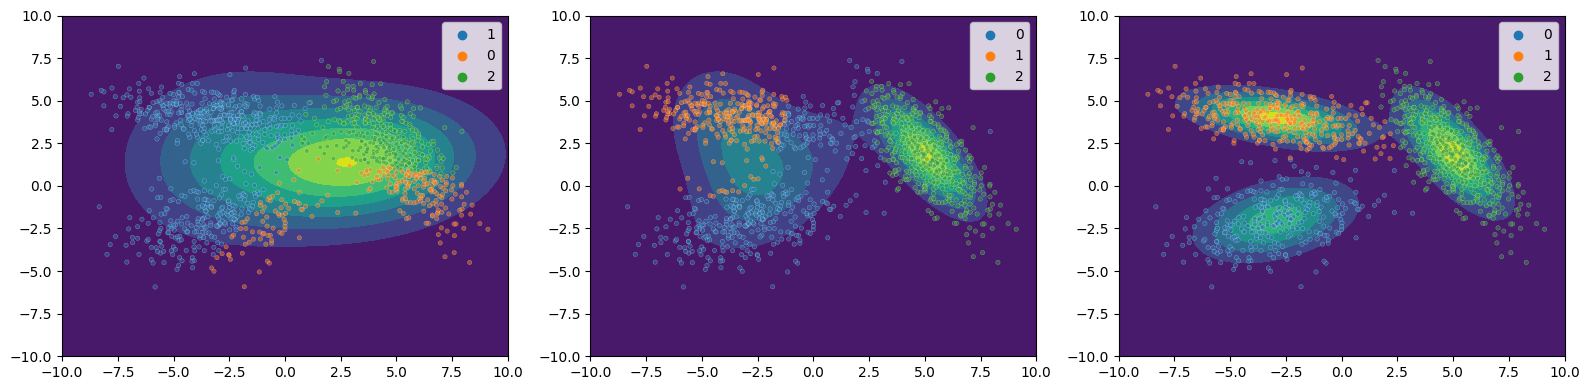

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
cnt = 0
for it in range(30):
    T = np.vstack([multivariate_normal.pdf(X, mean = m[i], cov = cov[i]) for i in range(n_mixture)]).T
    T = T / np.sum(T, axis=1, keepdims=True)

    T_sum = T.sum(axis=0)
    tau = T_sum / n
    T = T / T_sum
    m = np.array([np.dot(T[:, i], X) for i in range(n_mixture)]) 
    cov = list()
    for i in range(n_mixture):
        X_m = (X - m[i])
        cov.append(np.dot(X_m.T, T[:, i: i+1] * (X - m[i])))

    if it in [0, 15, 29]:
        # 2차원 다변량 가우시안 혼합 모델의 확률 밀도를 출력하기 위한
        # 출력 공간을 설정합니다.
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-10, 10, 100)
        xx, yy = np.meshgrid(x, y)
        xy = np.vstack((xx.ravel(), yy.ravel())).T
        # 확률 밀도를 계산합니다.
        Z = np.mean([multivariate_normal.pdf(xy, mean=m[i], cov=cov[i]) for i in range(n_mixture)], axis=0)
        # 등고 그래프를 통해 확률 밀도를 출력합니다,.
        axes[cnt].contourf(xx, yy, Z.reshape(xx.shape), cmap='viridis')
        
        sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.5, s=10, hue=np.argmax(T, axis=1).astype(str), ax=axes[cnt])
        cnt += 1
plt.tight_layout()
plt.show()

분포 1: mean = $\begin{bmatrix} -3 \\ -2 \end{bmatrix}$, cov=$\begin{bmatrix} 4 & 1 \\ 1 & 2 \end{bmatrix}$

분포 2: mean = $\begin{bmatrix} 5 \\ 2 \end{bmatrix}, cov=\begin{bmatrix} 2 & -2 \\ -2 & 4 \end{bmatrix}$

분포 3: mean = $\begin{bmatrix} -3 \\ 4 \end{bmatrix}, cov=\begin{bmatrix} 5 & -1 \\ -1 & 1 \end{bmatrix}$

In [31]:
# 학습한 모수를 출력합니다.
for m_, cov_ in zip(m, cov):
    print("mean:", np.round(m_, 2)) 
    print("cov:")
    print(np.round(cov_, 2))

mean: [-2.96 -2.  ]
cov:
[[4.44 1.08]
 [1.08 2.04]]
mean: [-2.9   3.99]
cov:
[[ 5.57 -1.09]
 [-1.09  0.99]]
mean: [5.02 1.92]
cov:
[[ 1.95 -1.99]
 [-1.99  4.02]]


**sklearn.mixture.GaussianMixture**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_components|군집수|
|n_init|초기화 및 학습 시행수|
|max_iter|EM 루틴의 수|

#### 장단점 비교

|모델|장점|단점|
|--|--|--|
|Kmeans, Kmedoid|이해하기 쉽고, 결과를 분석이 용이합니다.|군집의 개수를 정해주어야 합니다.<br/> 랜덤하게 정해진 초기 중심점때문에 결과가 매번 달라질 수 있어 일관성에서 부족합니다.|
|계층적 군집화|군집의 크기를 유연하게 정할수 있습니다.|연산량이 큽니다.|
|DBSCAN|군집의 크기를 정할 필요가 없습니다. <br/> 다양한 형태의 군집을 발견할 수 있습니다.|밀도가 높은 데이터에 적용이 어렵습니다.|
|혼합 기반 모델 |데이터가 기하학적 군집을 이룰 경우 성능이 좋습니다.|데이터의 수가 적을 경우 불안정한 결과를 보입니다.|